In [22]:
from qiskit import *
from qiskit.visualization import*
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit_aer import AerSimulator


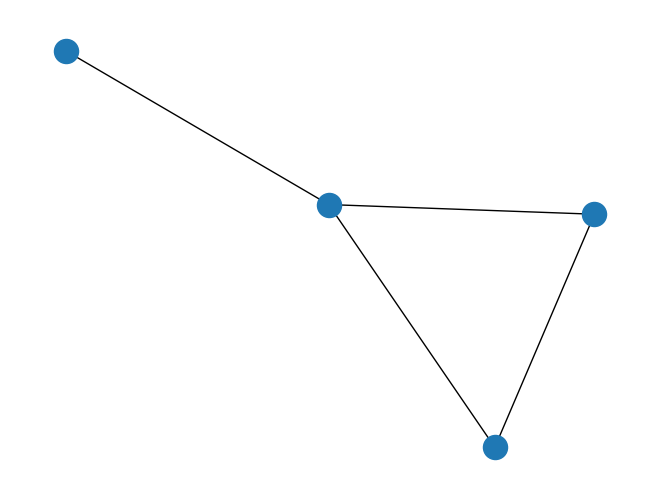

In [23]:
G = nx.Graph()
G.add_edges_from([[0,1],[1,2],[2,3],[3,1]])
#G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G)

In [24]:
def qaoa_ansatz(qc,G,beta,gamma):
    #using the algorithm write the code for qaoa ansatz

    for node in G.nodes:
        qc.rz(gamma,node) #problem 
    for node in G.nodes:  #mixer
        neighbors=list(G.neighbors(node))
        for i in neighbors:
            qc.x(i)
            #can use mcrx gate for a multi controlled gate
        qc.mcrx(2*beta,neighbors,node)
        for i in neighbors:
            qc.x(i)

        


In [25]:
for node in G.nodes:
    neighbors = list(G.neighbors(node))
    print(f"Node {node} has neighbors: {neighbors}")

Node 0 has neighbors: [1]
Node 1 has neighbors: [0, 2, 3]
Node 2 has neighbors: [1, 3]
Node 3 has neighbors: [2, 1]


┌───┐                         ┌───┐»
q_0: ────────────────────────┤ X ├────────────■────────────┤ X ├»
                             └─┬─┘            │            └─┬─┘»
q_1: ───────────■──────────────■──────────────┼──────────────■──»
     ┌──────────┴───────────┐     ┌───────────┴───────────┐     »
q_2: ┤ U(0.0615,-π/2,π/2,0) ├─────┤ U(-0.0615,-π/2,π/2,0) ├─────»
     └──────────────────────┘     └───────────────────────┘     »
«                             
«q_0: ───────────■────────────
«                │            
«q_1: ───────────┼────────────
«     ┌──────────┴───────────┐
«q_2: ┤ U(0.0615,-π/2,π/2,0) ├
«     └──────────────────────┘

In [26]:
def qaoa_circuit(G,beta,gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    for i in range(p):
        qaoa_ansatz(qc,G,beta[i],gamma[i])
    qc.measure(range(N),range(N))
    return qc

In [19]:
#verification
qc=qaoa_circuit(G,[np.pi/3],[np.pi/2])
qc.draw()

┌───┐┌─────────┐     ┌────────────────────┐┌───┐                          »
q_0: ┤ H ├┤ Rz(π/2) ├─────┤ U(2π/3,-π/2,π/2,0) ├┤ X ├──────────────────────────»
     ├───┤├─────────┤┌───┐└─────────┬──────────┘├───┤┌───────────────────┐     »
q_1: ┤ H ├┤ Rz(π/2) ├┤ X ├──────────■───────────┤ X ├┤ U(π/6,-π/2,π/2,0) ├─────»
     ├───┤├─────────┤├───┤                      └───┘└─────────┬─────────┘┌───┐»
q_2: ┤ H ├┤ Rz(π/2) ├┤ X ├─────────────────────────────────────┼──────────┤ X ├»
     ├───┤├─────────┤├───┤                                     │          └─┬─┘»
q_3: ┤ H ├┤ Rz(π/2) ├┤ X ├─────────────────────────────────────■────────────■──»
     └───┘└─────────┘└───┘                                                     »
c: 4/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                     ┌───┐»
«q_0: ────────────────────────────────────────────────┤ X ├»
«     ┌────────────────────┐     ┌───────────────────┐└─┬─┘»
«q_1: ┤ U(-π/6,-π/2,π/2,0) ├─────┤ U(π/6,-π/2,π/2,0) ├──┼──»
«     └─────────┬──────────┘┌───┐└─────────┬─────────┘  │  »
«q_2: ──────────■───────────┤ X ├──────────■────────────■──»
«                           └─┬─┘                          »
«q_3: ────────────────────────■────────────────────────────»
«                                                          »
«c: 4/═════════════════════════════════════════════════════»
«                                                          »
«                           ┌───┐                     ┌───┐»
«q_0: ──────────■───────────┤ X ├──────────■──────────┤ X ├»
«     ┌─────────┴──────────┐└─┬─┘┌─────────┴─────────┐└─┬─┘»
«q_1: ┤ U(-π/6,-π/2,π/2,0) ├──┼──┤ U(π/6,-π/2,π/2,0) ├──┼──»
«     └────────────────────┘  │  └───────────────────┘  │  »
«q_2: ────────────────────────┼─────────────────────────■──»
«                             │                            »
«q_3: ────────────────────────■────────────────────────────»
«                                                          »
«c: 4/═════════════════════════════════════════════════════»
«                                                          »
«                           ┌───┐                     ┌───┐»
«q_0: ──────────■───────────┤ X ├──────────■──────────┤ X ├»
«     ┌─────────┴──────────┐└─┬─┘┌─────────┴─────────┐├───┤»
«q_1: ┤ U(-π/6,-π/2,π/2,0) ├──┼──┤ U(π/6,-π/2,π/2,0) ├┤ X ├»
«     └───────┬───┬────────┘  │  └───────────────────┘└───┘»
«q_2: ────────┤ X ├───────────┼────────────────────────────»
«             └───┘           │          ┌───┐        ┌───┐»
«q_3: ────────────────────────■──────────┤ X ├────────┤ X ├»
«                                        └───┘        └───┘»
«c: 4/═════════════════════════════════════════════════════»
«                                                          »
«                          ┌─┐                                »
«q_0: ─────────────────────┤M├────────────────────────────────»
«                          └╥┘┌───┐                      ┌───┐»
«q_1: ──────────────────────╫─┤ X ├──────────■───────────┤ X ├»
«     ┌───────────────────┐ ║ └─┬─┘┌─────────┴──────────┐└─┬─┘»
«q_2: ┤ U(π/3,-π/2,π/2,0) ├─╫───┼──┤ U(-π/3,-π/2,π/2,0) ├──┼──»
«     └─────────┬─────────┘ ║   │  └────────────────────┘  │  »
«q_3: ──────────■───────────╫───■──────────────────────────■──»
«                           ║                                 »
«c: 4/══════════════════════╩═════════════════════════════════»
«                           0                                 »
«                                                              »
«q_0: ─────────────────────────────────────────────────────────»
«                          ┌───┐┌───┐                          »
«q_1: ──────────■──────────┤ X ├┤ X ├──────────■────────────■──»
«     ┌─────────┴─────────┐├───┤└───┘          │          ┌─┴─┐»
«q_2: ┤ U(π/3,-π/2,π/2,0) ├┤ X ├───────────────┼──────────┤ X ├»
«     └

In [27]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [27]:
simulator=AerSimulator()
qc1=transpile(qc,simulator)
result=simulator.run(qc,shots=1000).result()
counts = invert_counts(result.get_counts(qc1))


In [28]:
counts

{'1011': 11,
 '1111': 61,
 '0110': 64,
 '0001': 58,
 '0000': 313,
 '0101': 54,
 '1100': 83,
 '0011': 89,
 '1010': 3,
 '0010': 29,
 '0111': 59,
 '0100': 23,
 '1110': 71,
 '1101': 58,
 '1000': 23,
 '1001': 1}

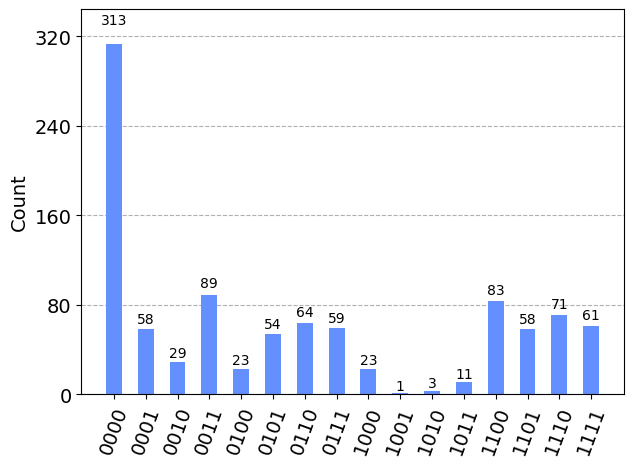

In [29]:
plot_histogram(counts)


In [28]:
def mis_obj(x,G):
    mis = 0
    for i,j in G.edges():
        if x[i]!=x[j]:
            mis-=1
        if x[i]==x[j]:
            mis+=2
    return mis



In [33]:
for i,j in G.edges():
    print(str(i) +" "+str(j))

0 1
1 2
1 3
2 3


In [29]:
def compute_mis_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = mis_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts



In [30]:
def get_black_box_objective(G,p):
    def f(theta):
        beta=theta[:p]
        gamma=theta[p:]
        qc=qaoa_circuit(G,beta,gamma)
        simulator=AerSimulator()
        qc1=transpile(qc,simulator)
        result=simulator.run(qc,shots=1000).result()
        counts =result.get_counts(qc1)
        return compute_mis_energy(invert_counts(counts),G)
    return f

        

In [31]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.74
       x: [ 1.709e+00  2.314e+00  7.152e-01  1.859e+00  2.878e-01
            2.428e+00  7.262e+00  3.203e+00  3.829e+00  6.118e+00]
    nfev: 103
   maxcv: 0.0

In [32]:
optimal_theta = res_sample['x']
qc = qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
simulator=AerSimulator()
qc1=transpile(qc,simulator)
result=simulator.run(qc,shots=1000).result()
counts =result.get_counts(qc1)
invert_counts(counts)

{'1011': 109,
 '0100': 72,
 '1000': 19,
 '1001': 273,
 '1110': 60,
 '0110': 63,
 '1100': 61,
 '0111': 69,
 '0101': 67,
 '1111': 66,
 '1101': 52,
 '1010': 45,
 '0001': 9,
 '0011': 14,
 '0010': 21}

In [33]:
# Find the bitstring with the maximum count in the measurement outcomes
max_bitstring = max(counts, key=lambda x: counts[x])

# Print the bitstring with the maximum count
print("Bit string with maximum count:", max_bitstring)

Bit string with maximum count: 1001


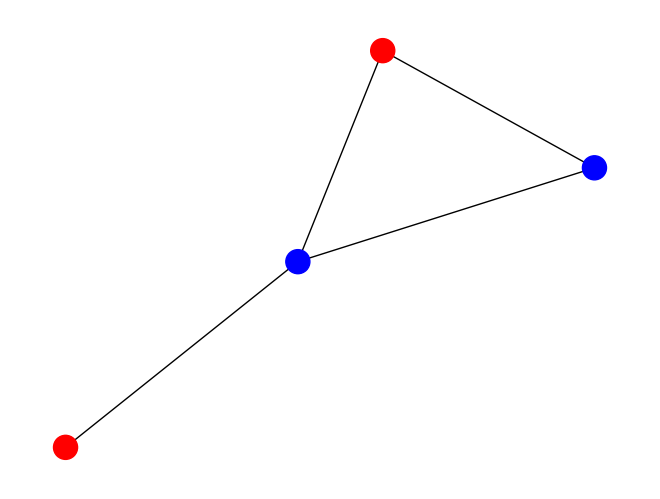

In [35]:
# get the best solution:
best_cut, best_solution = min([(mis_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))

# color the graph nodes by part
colors = ['r' if best_solution[node] == '1' else 'b' for node in G]
nx.draw(G,node_color = colors)

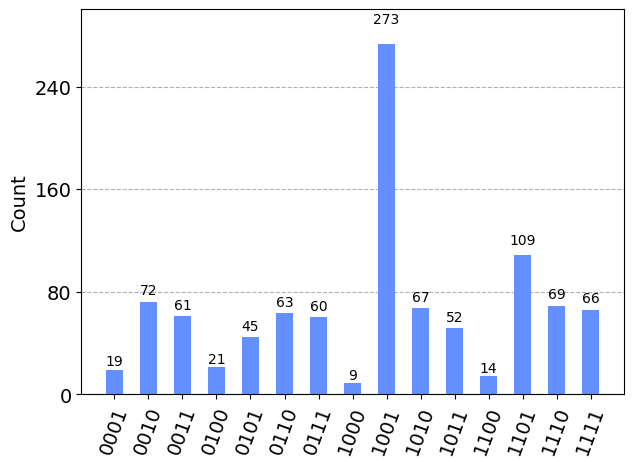

In [36]:
plot_histogram(counts)

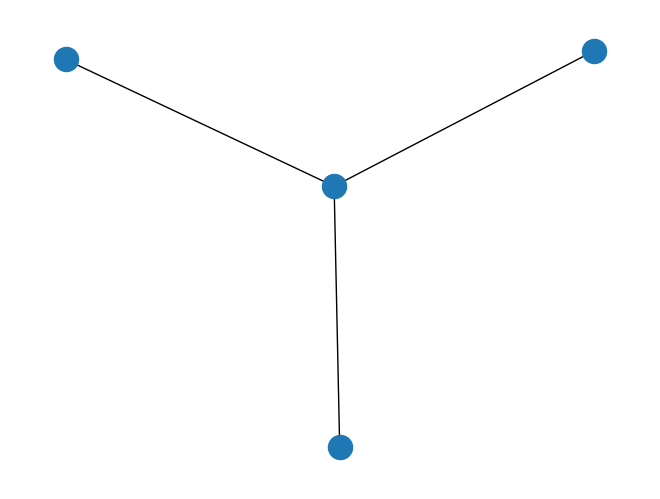

In [37]:
# G = nx.Graph()
# G.add_edges_from([[0,1],[1,2],[2,3],[3,1]])
G1=nx.Graph()
G1.add_edges_from([[0,1],[0,2],[0,3]])
nx.draw(G1)

In [38]:
p = 5
obj = get_black_box_objective(G1, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.669
       x: [ 7.684e-01  3.210e+00  8.727e-01  2.139e+00  3.534e-01
            2.437e+00  6.162e+00  2.243e+00  3.856e+00  6.129e+00]
    nfev: 105
   maxcv: 0.0

In [39]:
optimal_theta = res_sample['x']
qc = qaoa_circuit(G1, optimal_theta[:p], optimal_theta[p:])
simulator=AerSimulator()
qc1=transpile(qc,simulator)
result=simulator.run(qc,shots=1000).result()
counts =result.get_counts(qc1)
invert_counts(counts)

{'1100': 51,
 '0111': 227,
 '1010': 63,
 '1111': 56,
 '1001': 66,
 '1000': 288,
 '1101': 66,
 '1011': 73,
 '0110': 10,
 '0000': 3,
 '0101': 9,
 '1110': 75,
 '0011': 9,
 '0100': 2,
 '0001': 2}

In [40]:
# Find the bitstring with the maximum count in the measurement outcomes
max_bitstring = max(counts, key=lambda x: counts[x])

# Print the bitstring with the maximum count
print("Bit string with maximum count:", max_bitstring)

Bit string with maximum count: 0001


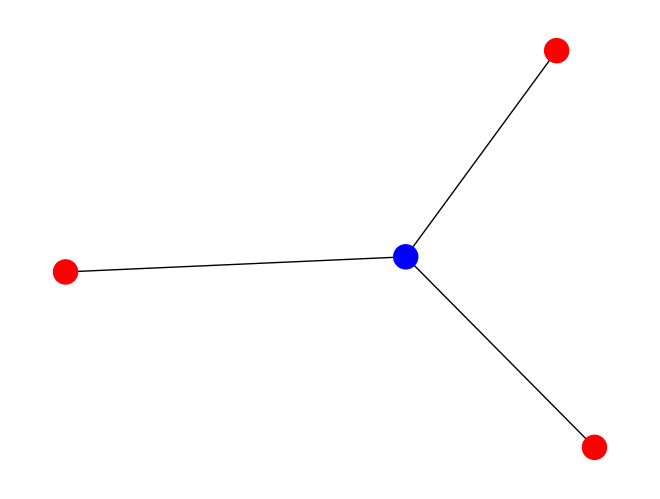

In [41]:
# get the best solution:
best_cut, best_solution = min([(mis_obj(x,G1),x) for x in counts.keys()], key=itemgetter(0))

# color the graph nodes by part
colors = ['r' if best_solution[node] == '1' else 'b' for node in G1]
nx.draw(G1,node_color = colors)